In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm
import time
import os
import matplotlib.pyplot as plt
import glob
from scipy import signal, stats
from scipy.stats import skew, kurtosis
from scipy.optimize import minimize_scalar
from scipy.stats import norm
import warnings
import sys
import joblib
import pickle

warnings.filterwarnings('ignore')

class Config:
    """
    Central configuration class. All paths, model parameters,
    and feature engineering settings are defined here.
    """
    BASE_PATH = '/kaggle/input/ariel-data-challenge-2025/'
    TRAIN_CSV = f"{BASE_PATH}/train.csv"
    TRAIN_STAR_INFO_CSV = f"{BASE_PATH}/train_star_info.csv"
    TEST_STAR_INFO_CSV = f"{BASE_PATH}/test_star_info.csv"
    ADC_INFO_CSV = f"{BASE_PATH}/adc_info.csv"
    TRAIN_DATA_PATH = f"{BASE_PATH}/train/"
    TEST_DATA_PATH = f"{BASE_PATH}/test/"

    SUBMISSION_FILE = 'submission.csv'
    MODEL_DIR = 'trained_models'
    IMPORTANCE_FILE = 'feature_importance.csv'

    QUICK_RUN = False
    QUICK_RUN_SIZE = 200

    ROLLING_WINDOWS = [50, 100, 500, 1000, 2000, 5000]
    DETREND_WINDOW = 5000
    AUTOCORR_LAGS = [10, 50, 100, 500, 1000]
    GRADIENT_WINDOWS = [10, 50, 100]
    N_SEGMENTS = 4

    N_SPLITS = 5
    LGBM_PARAMS = {
        "n_estimators": 500,
        "learning_rate": 0.05,
        "num_leaves": 127,
        "max_depth": 8,
        "min_child_samples": 20,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "reg_alpha": 0.1,
        "reg_lambda": 0.1,
        "random_state": 42,
        "verbose": -1
    }
    
    FSG_SIGMA_TRUE = 1e-6
    AIRS_SIGMA_TRUE = 1e-5
    FGS_WEIGHT = 0.4
    SIGMA_OPTIMIZE_BOUNDS = (0.25, 4.0)

def load_initial_data(cfg):
    """Loads the initial CSV files."""
    train_df = pd.read_csv(cfg.TRAIN_CSV)
    print("Train")
    display(train_df.head(2))

    train_star_info_df = pd.read_csv(cfg.TRAIN_STAR_INFO_CSV)
    print("Train Star Info")
    display(train_star_info_df.head(2))

    test_star_info_df = pd.read_csv(cfg.TEST_STAR_INFO_CSV)
    print("Test")
    display(test_star_info_df)

    if len(test_star_info_df) > 1:
        cfg.QUICK_RUN = False

    if cfg.QUICK_RUN:
        train_star_info_df = train_star_info_df.head(cfg.QUICK_RUN_SIZE)
        print(f"Only loading {cfg.QUICK_RUN_SIZE} records - this run is not a full training!")
    
    return train_df, train_star_info_df, test_star_info_df

def load_demo_data(cfg, train_star_info_df):
    """Loads a single planet's data for demonstration."""
    planet_id = int(train_star_info_df.iloc[0]['planet_id'])
    file_path = f"{cfg.TRAIN_DATA_PATH}{planet_id}/FGS1_signal_0.parquet"
    df = pd.read_parquet(file_path)
    signal_data = df.values.reshape(135000, 32, 32)
    print(f"Demo data loaded for Planet ID: {planet_id}")
    print(f"Signal data shape: {signal_data.shape}")
    print("="*60)
    return signal_data, planet_id

def apply_adc_correction(signal_array, instrument, adc_info_path):
    """Applies ADC correction to raw signal data using known gain and offset."""
    adc_df = pd.read_csv(adc_info_path)
    gain_col = f"{instrument}_adc_gain"
    offset_col = f"{instrument}_adc_offset"

    if gain_col not in adc_df.columns or offset_col not in adc_df.columns:
        raise ValueError(f"Missing columns: {gain_col} or {offset_col} in {adc_info_path}")
    
    gain = adc_df.at[0, gain_col]
    offset = adc_df.at[0, offset_col]

    calibrated_signal = signal_array.astype(np.float32) * gain + offset
    return calibrated_signal

def visualize_transit_data(signal_data, total_flux, planet_id):    
    base_frames = [0, len(signal_data)//4, len(signal_data)//2, 3*len(signal_data)//4, -1]

    brightest_idx = np.argmax(total_flux)
    darkest_idx = np.argmin(total_flux)

    extra_frames = []
    for idx in [brightest_idx, darkest_idx]:
        if idx not in base_frames and (idx != -1 and idx != len(signal_data)-1):
            extra_frames.append(idx)
    frames = base_frames + extra_frames

    plt.style.use('default')
    fig = plt.figure(figsize=(18, 10))
    
    for i, idx in enumerate(frames):
        ax = plt.subplot(2, len(frames), i + 1)
        frame = signal_data[idx]
        
        vmin, vmax = np.percentile(frame, [2, 98])
        im = ax.imshow(frame, cmap='hot', aspect='equal', vmin=vmin, vmax=vmax)
        
        time_min = idx * 0.1 / 60
        if idx == brightest_idx:
            title = f'Brightest\nT={time_min:.1f} min'
        elif idx == darkest_idx:
            title = f'Darkest\nT={time_min:.1f} min'
        else:
            title = f'T={time_min:.1f} min'
        ax.set_title(title, fontsize=11)
        ax.set_xticks([])
        ax.set_yticks([])
    
    ax_light = plt.subplot(2, 1, 2)
    time_hours = np.arange(len(total_flux)) * 0.1 / 3600
    sample = slice(None, None, max(1, len(total_flux)//2000))

    ax_light.plot(time_hours[sample], total_flux[sample], 
                  color='lightsteelblue', alpha=0.4, linewidth=0.5, label='Raw flux')

    window = 500
    moving_avg = pd.Series(total_flux).rolling(window, center=True).mean()
    ax_light.plot(time_hours[sample], moving_avg.iloc[sample], 
                  color='darkblue', linewidth=3, label=f'{window}-frame average')

    colors = ['red', 'orange', 'green', 'purple', 'brown', 'lime', 'black']
    for i, idx in enumerate(frames):
        time_point = idx * 0.1 / 3600
        ax_light.axvline(time_point, color=colors[i % len(colors)], alpha=0.8, linewidth=1.5, linestyle='--')

    ax_light.set_xlabel('Time (hours)', fontsize=12)
    ax_light.set_ylabel('Total Flux (counts)', fontsize=12)
    ax_light.set_title(f'Transit Light Curve - Planet {planet_id}', fontsize=14, pad=15)
    ax_light.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    ax_light.legend(loc='upper right', framealpha=0.9)

    smooth_flux = moving_avg.dropna()
    flux_min, flux_max = smooth_flux.min(), smooth_flux.max()
    flux_range = flux_max - flux_min
    margin = flux_range * 0.1
    ax_light.set_ylim(flux_min - margin, flux_max + margin)

    plt.tight_layout(pad=2.0)
    plt.show()

    duration = time_hours[-1]
    transit_depth = np.mean(total_flux) - np.min(total_flux)

    print(f"🌟 Planet {planet_id} Transit Observation")
    print(f"    Duration: {duration:.2f} hours ({len(signal_data):,} frames)")
    print(f"    Brightness: {np.min(total_flux):,.0f} → {np.max(total_flux):,.0f} counts")
    print(f"    Brightest Frame: {brightest_idx} | Darkest Frame: {darkest_idx}")
    print(f"    Transit depth: {transit_depth:,.0f} counts ({transit_depth/np.mean(total_flux)*100:.3f}%)")

def extract_global_flux_features(total_flux):
    features = {}
    features['global_flux_mean'] = np.mean(total_flux)
    features['global_flux_std'] = np.std(total_flux)
    features['global_flux_min'] = np.min(total_flux)
    features['global_flux_max'] = np.max(total_flux)
    features['global_flux_range'] = features['global_flux_max'] - features['global_flux_min']
    features['global_flux_skew'] = skew(total_flux)
    features['global_flux_kurtosis'] = kurtosis(total_flux)
    features['global_flux_cv'] = features['global_flux_std'] / features['global_flux_mean']
    for p in [1, 5, 10, 25, 50, 75, 90, 95, 99]:
        features[f'global_flux_p{p}'] = np.percentile(total_flux, p)
    features['global_flux_depth'] = features['global_flux_mean'] - features['global_flux_min']
    features['global_flux_depth_ratio'] = features['global_flux_depth'] / features['global_flux_mean']
    return features

def extract_rolling_statistics_features(total_flux, window_sizes):
    features = {}
    for window in window_sizes:
        if window < len(total_flux):
            rolling_mean = pd.Series(total_flux).rolling(window=window, center=True).mean().dropna()
            rolling_std = pd.Series(total_flux).rolling(window=window, center=True).std().dropna()
            rolling_min = pd.Series(total_flux).rolling(window=window, center=True).min().dropna()
            rolling_max = pd.Series(total_flux).rolling(window=window, center=True).max().dropna()
            if len(rolling_mean) > 0:
                features[f'rolling{window}_mean_min'] = rolling_mean.min()
                features[f'rolling{window}_mean_max'] = rolling_mean.max()
                features[f'rolling{window}_mean_std'] = rolling_mean.std()
                features[f'rolling{window}_mean_range'] = rolling_mean.max() - rolling_mean.min()
                features[f'rolling{window}_std_mean'] = rolling_std.mean()
                features[f'rolling{window}_std_max'] = rolling_std.max()
                features[f'rolling{window}_deepest_dip'] = rolling_min.min()
                features[f'rolling{window}_highest_peak'] = rolling_max.max()
                features[f'rolling{window}_volatility'] = rolling_std.std()
    return features

def extract_transit_detection_features(total_flux, detrend_window):
    features = {}
    baseline = pd.Series(total_flux).rolling(window=detrend_window, center=True).median().fillna(method='bfill').fillna(method='ffill')
    detrended = total_flux - baseline
    features['detrended_min'] = np.min(detrended)
    features['detrended_std'] = np.std(detrended)
    features['detrended_skew'] = skew(detrended)
    features['detrended_neg_excursions'] = np.sum(detrended < -2 * np.std(detrended))
    features['detrended_deep_excursions'] = np.sum(detrended < -3 * np.std(detrended))
    threshold = np.mean(total_flux) - 1.0 * np.std(total_flux)
    below_threshold = total_flux < threshold
    if np.any(below_threshold):
        diff = np.diff(np.concatenate(([False], below_threshold, [False])).astype(int))
        starts = np.where(diff == 1)[0]
        ends = np.where(diff == -1)[0]
        durations = ends - starts
        features['longest_dip_duration'] = np.max(durations) if len(durations) > 0 else 0
        features['num_dip_periods'] = len(durations)
        features['total_dip_time'] = np.sum(durations)
        features['avg_dip_duration'] = np.mean(durations) if len(durations) > 0 else 0
        deepest_idx = np.argmin(total_flux)
        features['deepest_time_fraction'] = deepest_idx / len(total_flux)
        features['deepest_in_first_half'] = float(deepest_idx < len(total_flux) / 2)
        features['deepest_in_middle_third'] = float(len(total_flux) / 3 < deepest_idx < 2 * len(total_flux) / 3)
        transit_flux = total_flux[below_threshold]
        features['transit_depth_mean'] = np.mean(transit_flux)
        features['transit_depth_std'] = np.std(transit_flux)
        features['transit_assymetry'] = skew(transit_flux)
        features['transit_flatness'] = kurtosis(transit_flux)
    else:
        features.update({
            'longest_dip_duration': 0, 'num_dip_periods': 0, 'total_dip_time': 0, 'avg_dip_duration': 0,
            'deepest_time_fraction': 0.5, 'deepest_in_first_half': 0, 'deepest_in_middle_third': 0,
            'transit_depth_mean': np.mean(total_flux), 'transit_depth_std': 0, 
            'transit_assymetry': 0, 'transit_flatness': 0
        })
    first_quarter = total_flux[:len(total_flux)//4]
    last_quarter = total_flux[-len(total_flux)//4:]
    middle_half = total_flux[len(total_flux)//4:-len(total_flux)//4]
    features['first_quarter_mean'] = np.mean(first_quarter)
    features['last_quarter_mean'] = np.mean(last_quarter)
    features['middle_half_mean'] = np.mean(middle_half)
    features['middle_vs_edges'] = features['middle_half_mean'] - (features['first_quarter_mean'] + features['last_quarter_mean']) / 2
    return features

def extract_frequency_features(total_flux, lag_list):
    features = {}
    fft_flux = np.fft.fft(total_flux - np.mean(total_flux))
    fft_power = np.abs(fft_flux)
    fft_freqs = np.fft.fftfreq(len(total_flux))
    features['fft_peak_power'] = np.max(fft_power[1:len(fft_power)//2])
    features['fft_total_power'] = np.sum(fft_power[1:len(fft_power)//2])
    features['fft_mean_power'] = np.mean(fft_power[1:len(fft_power)//2])
    features['fft_std_power'] = np.std(fft_power[1:len(fft_power)//2])
    low_freq_mask = np.abs(fft_freqs) < 0.01
    features['fft_low_freq_power'] = np.sum(fft_power[low_freq_mask])
    features['fft_low_freq_ratio'] = features['fft_low_freq_power'] / features['fft_total_power']
    power_spectrum = fft_power[1:len(fft_power)//2]
    freqs = np.abs(fft_freqs[1:len(fft_freqs)//2])
    if np.sum(power_spectrum) > 0:
        features['spectral_centroid'] = np.sum(freqs * power_spectrum) / np.sum(power_spectrum)
        features['spectral_bandwidth'] = np.sqrt(np.sum(((freqs - features['spectral_centroid'])**2) * power_spectrum) / np.sum(power_spectrum))
    else:
        features['spectral_centroid'] = 0
        features['spectral_bandwidth'] = 0
    autocorr = np.correlate(total_flux - np.mean(total_flux), total_flux - np.mean(total_flux), mode='full')
    autocorr = autocorr[autocorr.size // 2:]
    autocorr = autocorr / autocorr[0]
    for lag in lag_list:
        if lag < len(autocorr):
            features[f'autocorr_lag{lag}'] = autocorr[lag]
    peaks, _ = signal.find_peaks(autocorr[1:1000], height=0.1)
    features['autocorr_num_peaks'] = len(peaks)
    features['autocorr_first_peak'] = peaks[0] if len(peaks) > 0 else 0
    features['autocorr_strongest_peak'] = np.max(autocorr[peaks]) if len(peaks) > 0 else 0
    return features

def extract_spatial_features(signal_data):
    features = {}
    key_frames = [0, len(signal_data) // 4, len(signal_data) // 2, 3 * len(signal_data) // 4, -1]
    centroids_x, centroids_y, concentrations = [], [], []
    for i, frame_idx in enumerate(key_frames):
        frame = signal_data[frame_idx]
        y_indices, x_indices = np.indices(frame.shape)
        total_spatial_flux = np.sum(frame)
        if total_spatial_flux > 0:
            centroid_x = np.sum(x_indices * frame) / total_spatial_flux
            centroid_y = np.sum(y_indices * frame) / total_spatial_flux
        else:
            centroid_x = centroid_y = 16
        centroids_x.append(centroid_x)
        centroids_y.append(centroid_y)
        center_region = frame[12:20, 12:20]
        concentration = np.sum(center_region) / total_spatial_flux if total_spatial_flux > 0 else 0
        concentrations.append(concentration)
        features[f'frame{i}_spatial_mean'] = np.mean(frame)
        features[f'frame{i}_spatial_std'] = np.std(frame)
        features[f'frame{i}_centroid_x'] = centroid_x
        features[f'frame{i}_centroid_y'] = centroid_y
        features[f'frame{i}_concentration'] = concentration
    features['centroid_x_range'] = np.max(centroids_x) - np.min(centroids_x)
    features['centroid_y_range'] = np.max(centroids_y) - np.min(centroids_y)
    features['centroid_total_movement'] = np.sum(np.sqrt(np.diff(centroids_x)**2 + np.diff(centroids_y)**2))
    features['concentration_range'] = np.max(concentrations) - np.min(concentrations)
    features['concentration_std'] = np.std(concentrations)
    return features

def extract_gradient_features(total_flux, window_list, n_segments):
    features = {}
    total_flux = np.array(total_flux, dtype=np.float64)
    flux_diff1 = np.diff(total_flux)
    flux_diff2 = np.diff(flux_diff1)
    features['flux_diff1_mean'] = np.mean(flux_diff1)
    features['flux_diff1_std'] = np.std(flux_diff1)
    features['flux_diff1_min'] = np.min(flux_diff1)
    features['flux_diff1_max'] = np.max(flux_diff1)
    features['flux_diff1_range'] = features['flux_diff1_max'] - features['flux_diff1_min']
    features['flux_diff1_skew'] = skew(flux_diff1)
    features['flux_diff1_kurtosis'] = kurtosis(flux_diff1)
    features['flux_diff2_mean'] = np.mean(flux_diff2)
    features['flux_diff2_std'] = np.std(flux_diff2)
    features['flux_diff2_extremes'] = np.sum(np.abs(flux_diff2) > 3 * np.std(flux_diff2))
    for window in window_list:
        if window < len(flux_diff1):
            rolling_diff_std = pd.Series(flux_diff1).rolling(window=window).std()
            features[f'diff_volatility_w{window}_max'] = rolling_diff_std.max()
            features[f'diff_volatility_w{window}_mean'] = rolling_diff_std.mean()
    segments = n_segments
    segment_size = len(total_flux) // segments
    segment_means = []
    for i in range(segments):
        start_idx = i * segment_size
        end_idx = (i + 1) * segment_size if i < segments - 1 else len(total_flux)
        segment_flux = total_flux[start_idx:end_idx]
        if len(segment_flux) > 1:
            trend = np.polyfit(np.arange(len(segment_flux)), segment_flux, 1)[0]
            features[f'segment{i}_trend'] = trend
            features[f'segment{i}_mean'] = np.mean(segment_flux)
            features[f'segment{i}_std'] = np.std(segment_flux)
            features[f'segment{i}_range'] = np.max(segment_flux) - np.min(segment_flux)
            segment_means.append(features[f'segment{i}_mean'])
    features['segment_mean_range'] = np.max(segment_means) - np.min(segment_means)
    features['segment_mean_std'] = np.std(segment_means)
    global_mean = np.mean(total_flux)
    global_std = np.std(total_flux)
    transit_segments = sum(1 for mean in segment_means if mean < global_mean - global_std)
    features['num_transit_segments'] = transit_segments
    features['transit_segment_fraction'] = transit_segments / segments
    return features

def extract_enhanced_transit_features(signal_data, cfg, verbose=True):
    n_frames = signal_data.shape[0]
    signal_data = apply_adc_correction(signal_data, instrument='FGS1', adc_info_path=cfg.ADC_INFO_CSV)
    total_flux = np.sum(signal_data, axis=(1, 2))
    if verbose:
        print(f"Extracting enhanced transit features from {n_frames} frames...")
    features = {}
    features.update(extract_global_flux_features(total_flux))
    features.update(extract_rolling_statistics_features(total_flux, cfg.ROLLING_WINDOWS))
    features.update(extract_transit_detection_features(total_flux, cfg.DETREND_WINDOW))
    features.update(extract_frequency_features(total_flux, cfg.AUTOCORR_LAGS))
    features.update(extract_spatial_features(signal_data))
    features.update(extract_gradient_features(total_flux, cfg.GRADIENT_WINDOWS, cfg.N_SEGMENTS))
    if verbose:
        print(f"Generated {len(features)} enhanced transit features")
    return features

def prepare_data_with_enhanced_fgs1(train_df, star_info_df, cfg, dataset_type='train'):
    """Enhanced FGS1 feature extractor"""
    
    if dataset_type == 'train':
        data_path = cfg.TRAIN_DATA_PATH
    else:
        data_path = cfg.TEST_DATA_PATH

    print(f"Extracting enhanced FGS1 features for {len(star_info_df)} planets from {data_path}...")
    fgs1_features = []
    
    star_info_df['planet_id'] = star_info_df['planet_id'].astype(str)
    if train_df is not None:
        train_df['planet_id'] = train_df['planet_id'].astype(str)

    for i, row in star_info_df.iterrows():
        base_id = int(float(row['planet_id']))
        print(f"\rProcessing planet {i+1}/{len(star_info_df)} (ID: {base_id})", end='', flush=True)
        try:
            signal_paths = sorted(glob.glob(f"{data_path}{base_id}/FGS1_signal_*.parquet"))
            for j, path in enumerate(signal_paths):
                df = pd.read_parquet(path)
                signal = df.values.reshape(135000, 32, 32)
                features = extract_enhanced_transit_features(signal, cfg, verbose=False)
                signal_id = f"{base_id}_{j}"
                features['planet_id'] = signal_id
                fgs1_features.append(features)
        except Exception as e:
            print(f"\n❌ Failed to process planet {base_id}: {e}")
            continue

    print("\n✅ Feature extraction complete.")
    
    features_df = pd.DataFrame(fgs1_features)
    features_df['planet_id'] = features_df['planet_id'].astype(str)
    features_df = features_df.set_index('planet_id')
    print(f"→ Extracted features for {len(features_df)} entries with {features_df.shape[1]} columns")
    
    expanded_meta = []
    star_info_df['planet_id'] = star_info_df['planet_id'].apply(lambda x: str(int(float(x))))
    
    for pid in features_df.index:
        base_id = str(int(float(pid.split("_")[0])))
        row = star_info_df[star_info_df['planet_id'] == base_id].copy()
        if not row.empty:
            row['planet_id'] = pid
            expanded_meta.append(row)

    star_info_df_expanded = pd.concat(expanded_meta, ignore_index=True)
    full_df = star_info_df_expanded.set_index('planet_id').join(features_df, how='left')
    X = full_df.select_dtypes(include=[np.number]).fillna(0).astype(np.float32)

    if train_df is not None:
        targets_df = train_df.set_index('planet_id')
        extended_targets = []
        for pid in X.index:
            base_id = pid.split("_")[0]
            if base_id in targets_df.index:
                y_row = targets_df.loc[base_id].copy()
                y_row.name = pid
                extended_targets.append(y_row)
        y = pd.DataFrame(extended_targets).astype(np.float32)
        print(f"✅ Final shapes — X: {X.shape}, y: {y.shape}")
        return X, y
    else:
        print(f"✅ Final shape — X_test: {X.shape}")
        return X

def train_validate_multioutput_cv(X, y, cfg):
    print(f"Training with CV: {X.shape[1]} features → {y.shape[1]} wavelengths")
    
    kf = KFold(n_splits=cfg.N_SPLITS, shuffle=True, random_state=42)

    all_models = [[] for _ in range(y.shape[1])]
    all_fold_metrics = []

    oof_preds = np.zeros_like(y.values, dtype=float)
    oof_sigmas = np.zeros_like(y.values, dtype=float)
    residuals_all = [[] for _ in range(y.shape[1])]

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"\n🔁 Fold {fold+1}/{cfg.N_SPLITS}")
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        for i in tqdm(range(y.shape[1]), desc=f"Training wavelength models for Fold {fold+1}"):
            model = lgb.LGBMRegressor(**cfg.LGBM_PARAMS)

            y_single = y_train.iloc[:, i]
            model.fit(X_train, y_single)
            all_models[i].append(model)

            pred_val = model.predict(X_val)
            oof_preds[val_idx, i] = pred_val

            pred_train = model.predict(X_train)
            residuals = y_single - pred_train
            residuals_all[i].extend(residuals.tolist())

            sigma = np.std(residuals)
            oof_sigmas[val_idx, i] = max(sigma, 1e-6)

    target_uncertainties = [max(np.std(res), 1e-6) for res in residuals_all]
    r2_scores = [r2_score(y.values[:, i], oof_preds[:, i]) for i in range(y.shape[1])]
    rmses = [mean_squared_error(y.values[:, i], oof_preds[:, i], squared=False) for i in range(y.shape[1])]

    print("\n📊 CV Performance Summary:")
    print(f"→ Mean R²:    {np.mean(r2_scores):.4f}")
    print(f"→ Mean RMSE: {np.mean(rmses):.4f}")

    return {
        'models': all_models,
        'feature_columns': X.columns.tolist(),
        'target_columns': y.columns.tolist(),
        'oof_predictions': oof_preds,
        'oof_uncertainties': oof_sigmas,
        'y_true': y.values,
        'cv_metrics': {
            'r2_per_target': r2_scores,
            'rmse_per_target': rmses,
            'mean_r2': np.mean(r2_scores),
            'mean_rmse': np.mean(rmses)
        },
        'target_uncertainties': target_uncertainties
    }

def save_trained_models(model_dict, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    for target_idx, model_list in enumerate(model_dict['models']):
        for fold_idx, model in enumerate(model_list):
            model_path = os.path.join(save_dir, f'model_target{target_idx}_fold{fold_idx}.pkl')
            joblib.dump(model, model_path)
    metadata = {
        'feature_columns': model_dict['feature_columns'],
        'target_columns': model_dict['target_columns'],
        'cv_metrics': model_dict['cv_metrics'],
        'target_uncertainties': model_dict['target_uncertainties']
    }
    with open(os.path.join(save_dir, 'trained_model_info.pkl'), 'wb') as f:
        pickle.dump(metadata, f)
    print(f"✅ All models and metadata saved to: {save_dir}")

def analyze_feature_importance(trained_models, X, cfg, save_file=True):
    print(f"\n🔍 Feature Importance Analysis:")
    all_models_nested = trained_models['models']
    all_models_flat = [m for models_per_target in all_models_nested for m in models_per_target]
    
    feature_importance = pd.DataFrame({
        'feature': trained_models['feature_columns'],
        'importance': np.mean([model.feature_importances_ for model in all_models_flat], axis=0)
    }).sort_values('importance', ascending=False)
    
    print("Most important features:")
    for i, row in feature_importance.head(25).iterrows():
        print(f"  {i+1:2d}. {row['feature']:<35} {row['importance']:.4f}")
    
    categories = {}
    for _, row in feature_importance.iterrows():
        category = row['feature'].split('_')[0] if '_' in row['feature'] else 'other'
        categories.setdefault(category, []).append(row['importance'])
    
    print(f"\nFeature Category Performance:")
    for category, importances in sorted(categories.items(), key=lambda x: np.sum(x[1]), reverse=True):
        total_contrib = np.sum(importances) / feature_importance['importance'].sum() * 100
        print(f"  {category:<15}: {len(importances):>3d} features, {total_contrib:>5.1f}% contribution")
    
    zero_features = (feature_importance['importance'] == 0).sum()
    print(f"\nQuick Stats:")
    print(f"  Zero importance features: {zero_features}")
    print(f"  Top feature: {feature_importance.iloc[0]['feature']}")
    
    if save_file:
        feature_importance.to_csv(cfg.IMPORTANCE_FILE, index=False)
        print(f"\n💾 Saved feature importance to: {cfg.IMPORTANCE_FILE}")
    
    return feature_importance

def predict_with_uncertainty(models, X, fixed_uncertainty=None, target_uncertainties=None):
    predictions = []
    uncertainties = []
    is_cv = isinstance(models[0], list)
    n_targets = len(models)

    for i in range(n_targets):
        model_group = models[i] if is_cv else [models[i]]
        preds = []
        for model in model_group:
            preds.append(model.predict(X))
        
        pred_avg = np.mean(preds, axis=0)
        predictions.append(pred_avg)

        if fixed_uncertainty is not None:
            unc = fixed_uncertainty
        elif target_uncertainties is not None:
            unc = target_uncertainties[i]
        else:
            unc = 0.01  # fallback

        unc_array = np.full_like(pred_avg, max(unc, 1e-6))
        uncertainties.append(unc_array)

    y_pred = np.column_stack(predictions)
    sigma_pred = np.column_stack(uncertainties)
    
    pred_df = pd.DataFrame(y_pred).apply(pd.to_numeric, errors='coerce').fillna(0).clip(lower=0)
    sigma_df = pd.DataFrame(sigma_pred).apply(pd.to_numeric, errors='coerce').fillna(1e-6).clip(lower=1e-15)
    
    return pred_df.values, sigma_df.values

def score(solution, submission, row_id_column_name, naive_mean, naive_sigma,
          fsg_sigma_true, airs_sigma_true, fgs_weight):
    y_true = solution.drop(columns=[row_id_column_name])
    y_pred = submission[[col for col in submission.columns if not col.endswith('_std') and col != row_id_column_name]]
    sigma = submission[[col for col in submission.columns if col.endswith('_std')]]
    log_likelihoods = -0.5 * np.log(2 * np.pi * sigma.values ** 2) - ((y_true.values - y_pred.values) ** 2) / (2 * sigma.values ** 2)
    gll = np.mean(log_likelihoods)
    return np.clip((gll + 10) / 10, 0, 1)

def evaluate_with_gll_metric(y_true, y_pred, sigma_pred, naive_mean, naive_sigma, cfg):
    if not isinstance(y_true, pd.DataFrame):
        y_true = pd.DataFrame(y_true)
    y_true = y_true.reset_index(drop=True)
    n_samples, n_waves = y_pred.shape
    sigma_pred = np.clip(sigma_pred, 1e-15, None)
    solution_df = y_true.copy()
    solution_df['row_id'] = np.arange(n_samples)
    submission_df = pd.DataFrame()
    for i in range(n_waves):
        submission_df[f'wavelength_{i}'] = y_pred[:, i]
    for i in range(n_waves):
        submission_df[f'wavelength_{i}_std'] = sigma_pred[:, i]
    submission_df['row_id'] = np.arange(n_samples)
    submission_df = submission_df.clip(lower=1e-15)
    
    gll_score = score(
        solution=solution_df, submission=submission_df,
        row_id_column_name='row_id', naive_mean=naive_mean, naive_sigma=naive_sigma,
        fsg_sigma_true=cfg.FSG_SIGMA_TRUE, airs_sigma_true=cfg.AIRS_SIGMA_TRUE, fgs_weight=cfg.FGS_WEIGHT
    )
    return gll_score

def fast_gll_score_numpy(y_true, y_pred, sigma_pred, naive_mean, naive_sigma, cfg):
    sigma_pred = np.clip(sigma_pred, 1e-15, None)
    n_samples, n_waves = sigma_pred.shape
    sigma_true = np.append([cfg.FSG_SIGMA_TRUE], np.full(n_waves - 1, cfg.AIRS_SIGMA_TRUE))
    sigma_true = np.tile(sigma_true, (n_samples, 1))
    weights = np.append([cfg.FGS_WEIGHT], np.ones(n_waves - 1))
    weights = np.tile(weights, (n_samples, 1))
    gll_pred = norm.logpdf(y_true, loc=y_pred, scale=sigma_pred)
    gll_true = norm.logpdf(y_true, loc=y_true, scale=sigma_true)
    gll_naive = norm.logpdf(y_true, loc=naive_mean, scale=naive_sigma)
    ind_scores = (gll_pred - gll_naive) / (gll_true - gll_naive + 1e-9)
    final_score = np.average(ind_scores, weights=weights)
    return float(np.clip(final_score, 0.0, 1.0))

def optimize_sigma_per_wavelength(y_true, y_pred, sigma_pred, naive_mean, naive_sigma, cfg):
    n_waves = sigma_pred.shape[1]
    best_scales = np.ones(n_waves)
    print(f"⚡ Optimizing {n_waves} sigma scalers with fast NumPy GLL metric...\n")
    for i in tqdm(range(n_waves), desc="Optimizing wavelengths", unit="λ"):
        def objective(scale):
            sigma_scaled = sigma_pred.copy()
            sigma_scaled[:, i] *= scale
            return -fast_gll_score_numpy(y_true, y_pred, sigma_scaled, naive_mean, naive_sigma, cfg)
        
        result = minimize_scalar(objective, bounds=cfg.SIGMA_OPTIMIZE_BOUNDS, method='bounded')
        best_scales[i] = result.x
    print("✅ Optimization complete.")
    return best_scales

def create_submission(trained_models, test_star_info_df, cfg, sigma_scalers=None):
    X_test = prepare_data_with_enhanced_fgs1(
        train_df=None,
        star_info_df=test_star_info_df,
        cfg=cfg,
        dataset_type='test'
    )
    
    X_test_aligned = X_test.reindex(columns=trained_models['feature_columns'], fill_value=0)

    y_pred, sigma_pred = predict_with_uncertainty(
        trained_models['models'],
        X_test_aligned,
        target_uncertainties=trained_models['target_uncertainties']
    )

    if sigma_scalers is not None:
        sigma_pred = sigma_pred * sigma_scalers

    base_ids = [idx.split("_")[0] for idx in X_test_aligned.index]
    wl_cols = trained_models['target_columns']
    sigma_cols = [f"sigma_{i+1}" for i in range(y_pred.shape[1])]

    pred_df = pd.DataFrame(y_pred, index=base_ids, columns=wl_cols)
    sigma_df = pd.DataFrame(sigma_pred, index=base_ids, columns=sigma_cols)

    pred_mean = pred_df.groupby(pred_df.index).mean()
    sigma_mean = sigma_df.groupby(sigma_df.index).mean()

    submission_df = pd.concat([pred_mean, sigma_mean], axis=1).reset_index()
    submission_df = submission_df.rename(columns={'index': 'planet_id'})
    submission_df['planet_id'] = submission_df['planet_id'].astype(int)

    submission_df.to_csv(cfg.SUBMISSION_FILE, index=False, float_format='%.5f')
    print(f"✅ Submission saved to: {cfg.SUBMISSION_FILE}")
    
    return submission_df

main_start_time = time.time()

cfg = Config()

train_df, train_star_info_df, test_star_info_df = load_initial_data(cfg)

if cfg.QUICK_RUN:
    print("--- Running Demo Cell ---")
    demo_start = time.time()
    demo_signal, demo_pid = load_demo_data(cfg, train_star_info_df)
    demo_flux = np.sum(apply_adc_correction(demo_signal, 'FGS1', cfg.ADC_INFO_CSV), axis=(1, 2))
    
    visualize_transit_data(demo_signal, demo_flux, demo_pid)
    
    all_features = extract_enhanced_transit_features(demo_signal, cfg, verbose=True)
    print(f"--- Demo Cell Finished ({time.time() - demo_start:.2f}s) ---")

print("--- Preparing Training Data ---")
prep_start = time.time()
X, y = prepare_data_with_enhanced_fgs1(train_df, train_star_info_df, cfg, dataset_type='train')
print(f"--- Training Data Prepared ({time.time() - prep_start:.2f}s) ---")

print("--- Training Model ---")
train_start = time.time()
trained_models_cv = train_validate_multioutput_cv(X, y, cfg)
print(f"--- Model Training Finished ({time.time() - train_start:.2f}s) ---")

print("--- Saving & Analyzing Model ---")
save_trained_models(trained_models_cv, save_dir=cfg.MODEL_DIR)
feature_importance_df = analyze_feature_importance(trained_models_cv, X, cfg)

print("--- Running Dummy GLL Score ---")
y_true_oof = trained_models_cv['y_true']
y_pred_oof = trained_models_cv['oof_predictions']
sigma_pred_oof = trained_models_cv['oof_uncertainties']
naive_mean = y_true_oof.mean()
naive_sigma = y_true_oof.std()

best_scales = optimize_sigma_per_wavelength(
    y_true_oof, y_pred_oof, sigma_pred_oof,
    naive_mean, naive_sigma, cfg
)

final_score = fast_gll_score_numpy(
    y_true_oof, y_pred_oof, sigma_pred_oof * best_scales,
    naive_mean, naive_sigma, cfg
)
print(f"🎯 Calibrated OOF GLL Score: {final_score:.6f}")

print("--- Creating Submission ---")
sub_start = time.time()
submission = create_submission(
    trained_models_cv,
    test_star_info_df,
    cfg,
    sigma_scalers=best_scales
)
print(f"--- Submission Created ({time.time() - sub_start:.2f}s) ---")

print("\n--- 🚀 Pipeline Finished ---")
display(submission.head())
print(f"Total runtime: {(time.time() - main_start_time) / 60:.2f} minutes")

Train


,planet_id,wl_1,wl_2,wl_3,wl_4,wl_5,wl_6,wl_7,wl_8,wl_9,...,wl_274,wl_275,wl_276,wl_277,wl_278,wl_279,wl_280,wl_281,wl_282,wl_283
0,34983,0.018291,0.018088,0.018087,0.018085,0.018084,0.018084,0.018084,0.018084,0.018085,...,0.018109,0.018112,0.018118,0.018123,0.018125,0.018127,0.018130,0.018134,0.018138,0.018142
1,1873185,0.006347,0.006343,0.006343,0.006343,0.006343,0.006343,0.006343,0.006342,0.006342,...,0.006340,0.006340,0.006339,0.006339,0.006339,0.006339,0.006339,0.006339,0.006339,0.006339


Train Star Info


,planet_id,Rs,Ms,Ts,Mp,e,P,sma,i
0,34983,1.155435,1.062961,5577.006645,0.694946,0.0,3.305589,8.550786,89.150759
1,1873185,1.813230,1.370451,6216.229756,0.610845,0.0,6.352660,9.553384,88.701514


Test


,planet_id,Rs,Ms,Ts,Mp,e,P,sma,i
0,1103775.0,0.965432,0.9591,5539.03037,1.665007,0.0,6.932871,15.43293,89.533139


--- Preparing Training Data ---
Extracting enhanced FGS1 features for 1100 planets from /kaggle/input/ariel-data-challenge-2025//train/...
Processing planet 1100/1100 (ID: 4294092928)
✅ Feature extraction complete.
→ Extracted features for 1210 entries with 175 columns
✅ Final shapes — X: (1210, 183), y: (1210, 283)
--- Training Data Prepared (5586.76s) ---
--- Training Model ---
Training with CV: 183 features → 283 wavelengths

🔁 Fold 1/5


Training wavelength models for Fold 1: 100%|██████████| 283/283 [02:09<00:00,  2.18it/s]



🔁 Fold 2/5


Training wavelength models for Fold 2: 100%|██████████| 283/283 [02:34<00:00,  1.84it/s]



🔁 Fold 3/5


Training wavelength models for Fold 3: 100%|██████████| 283/283 [02:10<00:00,  2.16it/s]



🔁 Fold 4/5


Training wavelength models for Fold 4: 100%|██████████| 283/283 [02:11<00:00,  2.16it/s]



🔁 Fold 5/5


Training wavelength models for Fold 5: 100%|██████████| 283/283 [02:01<00:00,  2.32it/s]



📊 CV Performance Summary:
→ Mean R²:    0.9584
→ Mean RMSE: 0.0022
--- Model Training Finished (668.25s) ---
--- Saving & Analyzing Model ---
✅ All models and metadata saved to: trained_models

🔍 Feature Importance Analysis:
Most important features:
  117. autocorr_strongest_peak             309.5880
  95. transit_depth_std                   199.1908
  88. num_dip_periods                     118.9364
   7. sma                                 62.9830
  114. autocorr_lag1000                    59.6304
  109. spectral_bandwidth                  50.4714
  107. fft_low_freq_ratio                  50.3823
  154. flux_diff1_kurtosis                 46.8367
  14. global_flux_skew                    45.0488
  168. segment1_trend                      42.1314
  176. segment3_trend                      40.4141
   6. P                                   40.0523
  81. rolling5000_volatility              31.8565
  76. rolling5000_mean_range              31.4148
  164. segment0_trend                  

Optimizing wavelengths: 100%|██████████| 283/283 [03:11<00:00,  1.48λ/s]

✅ Optimization complete.
🎯 Calibrated OOF GLL Score: 0.227574
--- Creating Submission ---
Extracting enhanced FGS1 features for 1 planets from /kaggle/input/ariel-data-challenge-2025//test/...
Processing planet 1/1 (ID: 1103775)


✅ Feature extraction complete.
→ Extracted features for 2 entries with 175 columns
✅ Final shape — X_test: (2, 183)
✅ Submission saved to: submission.csv
--- Submission Created (13.04s) ---

--- 🚀 Pipeline Finished ---


,planet_id,wl_1,wl_2,wl_3,wl_4,wl_5,wl_6,wl_7,wl_8,wl_9,...,sigma_274,sigma_275,sigma_276,sigma_277,sigma_278,sigma_279,sigma_280,sigma_281,sigma_282,sigma_283
0,1103775,0.016512,0.016528,0.01659,0.016608,0.016465,0.016555,0.016586,0.016555,0.016521,...,0.00171,0.001715,0.001701,0.001695,0.0017,0.001702,0.001695,0.001696,0.001692,0.001688


Total runtime: 107.84 minutes


--- Saving & Analyzing Model ---
✅ All models and metadata saved to: trained_models

🔍 Feature Importance Analysis:
Most important features:
  117. autocorr_strongest_peak             309.5880
  95. transit_depth_std                   199.1908
  88. num_dip_periods                     118.9364
   7. sma                                 62.9830
  114. autocorr_lag1000                    59.6304
  109. spectral_bandwidth                  50.4714
  107. fft_low_freq_ratio                  50.3823
  154. flux_diff1_kurtosis                 46.8367
  14. global_flux_skew                    45.0488
  168. segment1_trend                      42.1314
  176. segment3_trend                      40.4141
   6. P                                   40.0523
  81. rolling5000_volatility              31.8565
  76. rolling5000_mean_range              31.4148
  164. segment0_trend                      31.3279
  179. segment3_range                      27.1004
  89. total_dip_time                      26.64

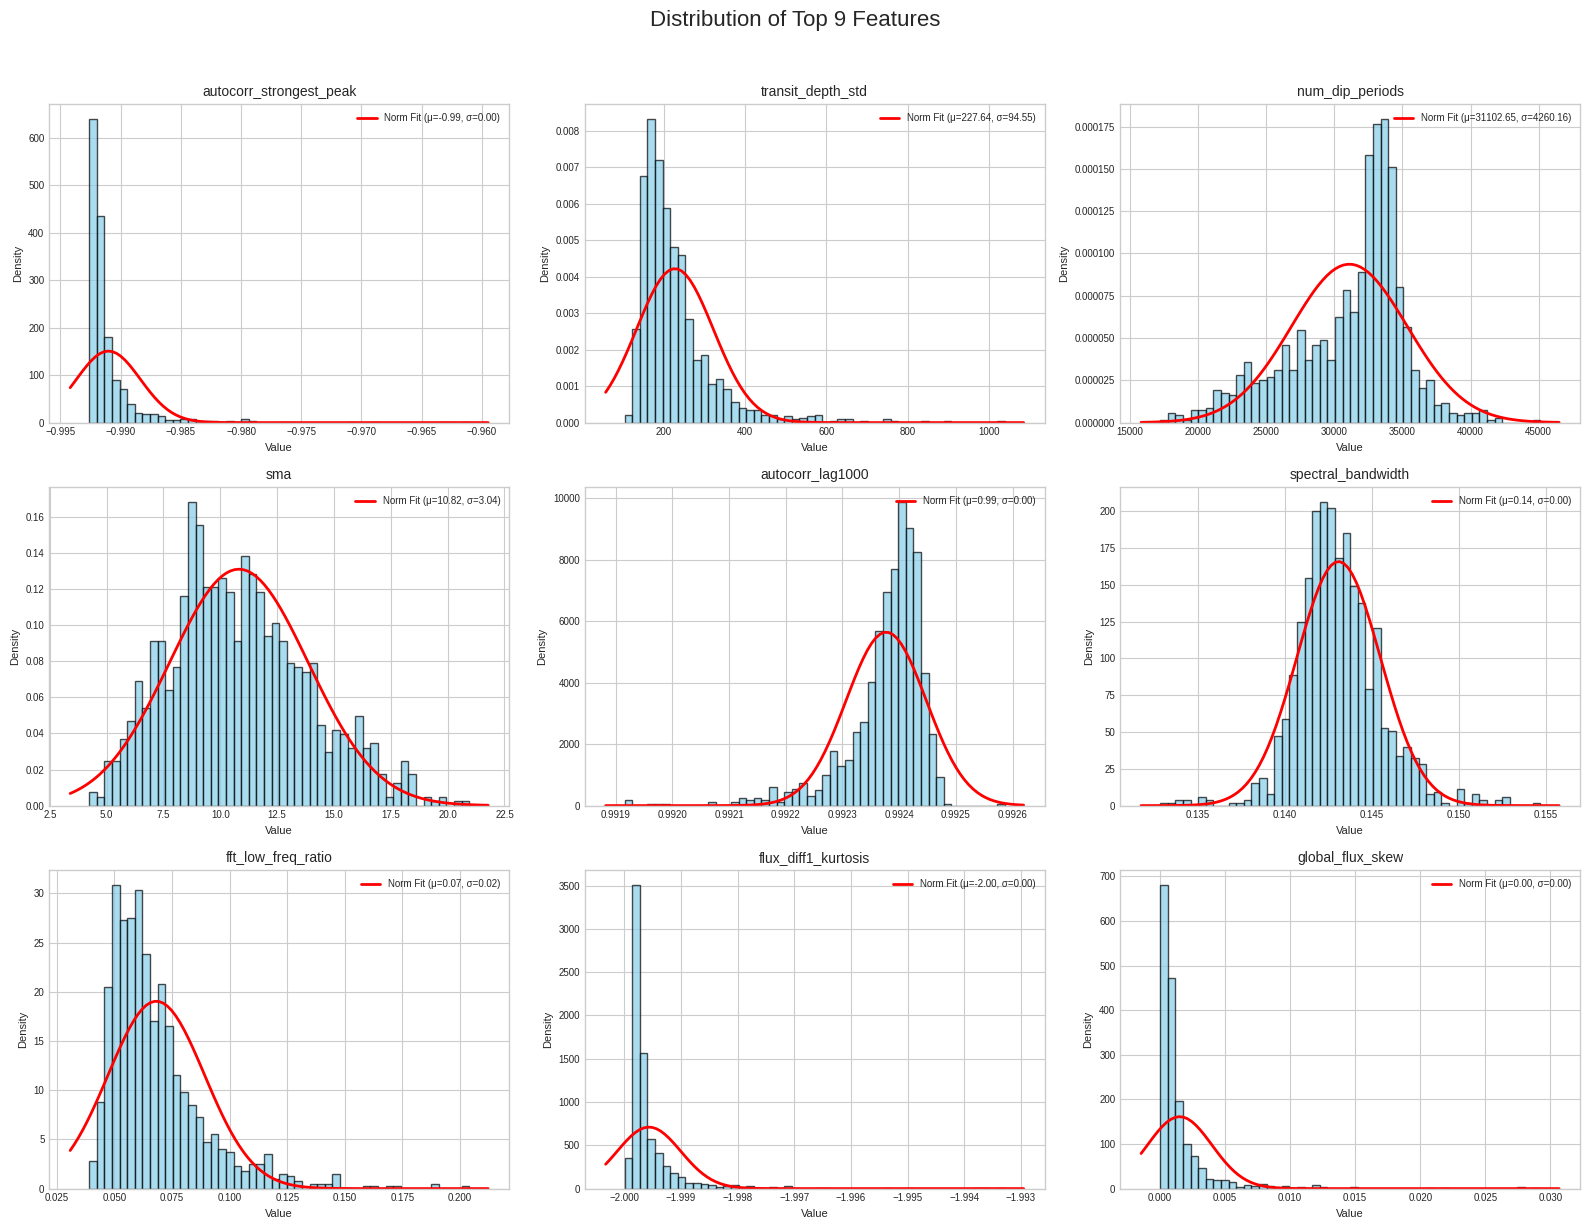

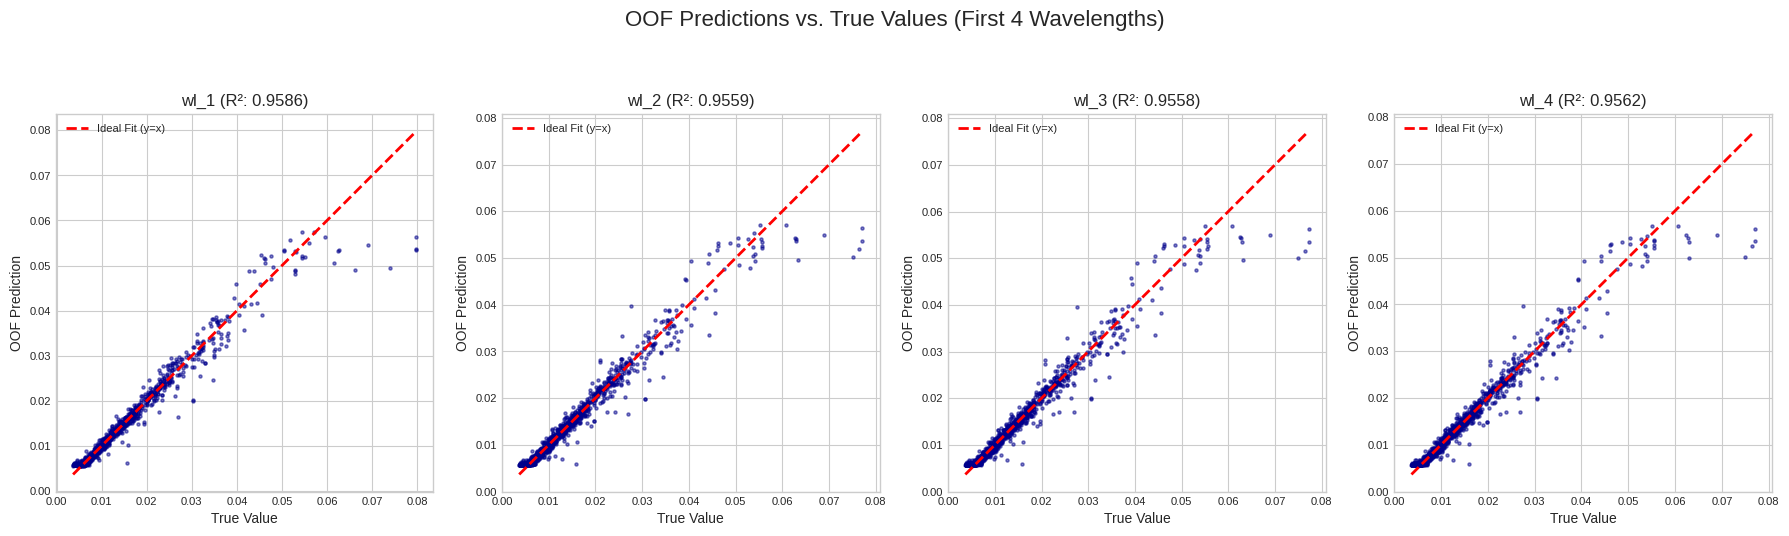

--- Running Dummy GLL Score ---


In [3]:
# ... (Continuing from the end of the original script's main execution block)

# --- 6. Save & Analyze Model ---
print("--- Saving & Analyzing Model ---")
save_trained_models(trained_models_cv, save_dir=cfg.MODEL_DIR)
feature_importance_df = analyze_feature_importance(trained_models_cv, X, cfg)

## ===================================================================
## Data Visualization and Analysis
## ===================================================================

# Define the visualization functions here (or ensure they are defined globally)
def plot_feature_distributions(X, feature_importance_df, n_features=9):
    """Plots the distribution of the top N features."""
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Select the top N features
    top_features = feature_importance_df.head(n_features)['feature'].tolist()
    
    # Calculate the grid size
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
    axes = axes.flatten()

    fig.suptitle(f'Distribution of Top {n_features} Features', fontsize=16, y=1.02)
    
    for i, feature in enumerate(top_features):
        ax = axes[i]
        data = X[feature].dropna()
        
        # Plot histogram
        data.hist(ax=ax, bins=50, color='skyblue', edgecolor='black', alpha=0.7, density=True)
        
        # Fit a normal distribution for comparison
        mu, std = norm.fit(data)
        xmin, xmax = ax.get_xlim()
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mu, std)
        ax.plot(x, p, 'r', linewidth=2, label=f'Norm Fit (μ={mu:.2f}, σ={std:.2f})')
        
        ax.set_title(feature, fontsize=10)
        ax.set_xlabel('Value', fontsize=8)
        ax.set_ylabel('Density', fontsize=8)
        ax.tick_params(axis='both', which='major', labelsize=7)
        ax.legend(fontsize=7, loc='upper right')

    # Hide unused subplots
    for i in range(n_features, len(axes)):
        fig.delaxes(axes[i])
        
    plt.tight_layout()
    plt.show()

def plot_oof_predictions(y_true, y_pred, target_columns, n_targets=4):
    """Plots OOF predictions vs True values for the first N target wavelengths."""
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Select the first N targets
    n_targets = min(n_targets, y_true.shape[1])
    
    fig, axes = plt.subplots(1, n_targets, figsize=(18, 5))
    
    fig.suptitle(f'OOF Predictions vs. True Values (First {n_targets} Wavelengths)', fontsize=16, y=1.05)
    
    for i in range(n_targets):
        ax = axes[i]
        true_values = y_true[:, i]
        pred_values = y_pred[:, i]
        
        # Scatter plot
        ax.scatter(true_values, pred_values, alpha=0.5, s=5, color='darkblue')
        
        # Add the ideal y=x line
        min_val = min(true_values.min(), pred_values.min())
        max_val = max(true_values.max(), pred_values.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Ideal Fit (y=x)')
        
        # Calculate R2 for the plot title
        r2 = r2_score(true_values, pred_values)
        
        ax.set_title(f'{target_columns[i]} (R²: {r2:.4f})', fontsize=12)
        ax.set_xlabel('True Value', fontsize=10)
        ax.set_ylabel('OOF Prediction', fontsize=10)
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.set_aspect('equal', adjustable='box')
        ax.legend(fontsize=8)
        
    plt.tight_layout()
    plt.show()

print("\n--- 🖼️ Visualization Stage ---")

# 1. Plot feature distributions (X and feature_importance_df are now defined)
plot_feature_distributions(X, feature_importance_df, n_features=9)

# 2. Plot OOF predictions vs True values (trained_models_cv is now defined)
plot_oof_predictions(
    y_true=trained_models_cv['y_true'],
    y_pred=trained_models_cv['oof_predictions'],
    target_columns=trained_models_cv['target_columns'],
    n_targets=4 # Plotting the first 4 wavelengths
)

# --- 7. Dummy Score (for demonstration) ---
print("--- Running Dummy GLL Score ---")
# ... (rest of the script)